In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import time

# Prédiction du prix du loyer
Dataset: https://www.kaggle.com/datasets/denkuznetz/housing-prices-regression/data

Ce notebook introduit  un cas pratique d'utilisation de  régression linéaire pour la prévision des prix de location. Les valeurs observées (utilisées pour faire la prédiction) sont les suivantes :
- pieds_carres
- nombre_chambres
- nombre_douches
- annee_construction
- avec_jardin
- taille_garage
- score_localisation
- distance_centre_ville

## Pandas
Permet de manipuler des données structurées.

In [22]:
data=pd.read_csv('src/data1.csv')#Lire le fichier csv.
data.head()#Affiche les 5 premières lignes du dataframe.

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386
2,3,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.696880
3,4,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.655996
4,5,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.142523


In [23]:
#Renommer les colonnes en français
nouveaux_noms_colonnes={
    "Square_Feet":"pieds_carres",#Evitez de nommer les colonnes comme suit: pieds carrés
    "Num_Bedrooms":"nombre_chambres",
    "Num_Bathrooms":"nombre_douches",
    "Num_Floors":"nombre_etages",
    "Year_Built":"annee_construction",
    "Has_Garden":"avec_jardin",
    "Has_Pool":"avec_piscine",
    "Garage_Size":"taille_garage",
    "Location_Score":"score_localisation",
    "Distance_to_Center":"distance_centre_ville",
    "Price":"prix"
}

data.rename(columns=nouveaux_noms_colonnes,inplace=True)
#Inplace permet de modifier directement le dataframe. Sa valeur par défaut est False.
#Si vous auriez défini inplace à False vous auriez dû réaffecter la valeur data comme ci dessous.
# data=data.rename(columns=nouveaux_noms_colonnes,inplace=False)
data.head(2)

,ID,pieds_carres,nombre_chambres,nombre_douches,nombre_etages,annee_construction,avec_jardin,avec_piscine,taille_garage,score_localisation,distance_centre_ville,prix
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386


In [24]:
#Divisons les prix par 100000 pour avoir des valeurs plus petites.
data['prix']=data['prix'].apply(lambda x: x/10000)
data.head(2)

,ID,pieds_carres,nombre_chambres,nombre_douches,nombre_etages,annee_construction,avec_jardin,avec_piscine,taille_garage,score_localisation,distance_centre_ville,prix
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,60.213482
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,59.142514


In [25]:
data.info()#Info sur les colonnes et sur le dataframe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     500 non-null    int64  
 1   pieds_carres           500 non-null    float64
 2   nombre_chambres        500 non-null    int64  
 3   nombre_douches         500 non-null    int64  
 4   nombre_etages          500 non-null    int64  
 5   annee_construction     500 non-null    int64  
 6   avec_jardin            500 non-null    int64  
 7   avec_piscine           500 non-null    int64  
 8   taille_garage          500 non-null    int64  
 9   score_localisation     500 non-null    float64
 10  distance_centre_ville  500 non-null    float64
 11  prix                   500 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 47.0 KB


Changons le type de données des colonnes catégorielles/discrètes listé ci-dessous  en type object pour des raisons d'études statistiques: 
- avec_jardin
- avec_piscine
- annee_construction

In [26]:
data[['avec_jardin','avec_piscine','annee_construction']]=data[['avec_jardin','avec_piscine','annee_construction']].astype(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     500 non-null    int64  
 1   pieds_carres           500 non-null    float64
 2   nombre_chambres        500 non-null    int64  
 3   nombre_douches         500 non-null    int64  
 4   nombre_etages          500 non-null    int64  
 5   annee_construction     500 non-null    object 
 6   avec_jardin            500 non-null    object 
 7   avec_piscine           500 non-null    object 
 8   taille_garage          500 non-null    int64  
 9   score_localisation     500 non-null    float64
 10  distance_centre_ville  500 non-null    float64
 11  prix                   500 non-null    float64
dtypes: float64(4), int64(5), object(3)
memory usage: 47.0+ KB


In [27]:
data.describe()#Statistique des données numériques.

,ID,pieds_carres,nombre_chambres,nombre_douches,nombre_etages,taille_garage,score_localisation,distance_centre_ville,prix
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,174.640428,2.958000,1.976000,1.964000,30.174000,5.164410,10.469641,58.220963
std,144.481833,74.672102,1.440968,0.820225,0.802491,11.582575,2.853489,5.588197,12.227339
min,1.000000,51.265396,1.000000,1.000000,1.000000,10.000000,0.004428,0.062818,27.689247
25%,125.750000,110.319923,2.000000,1.000000,1.000000,20.000000,2.760650,6.066754,50.308034
50%,250.500000,178.290937,3.000000,2.000000,2.000000,30.000000,5.206518,10.886066,57.472411
75%,375.250000,239.031220,4.000000,3.000000,3.000000,41.000000,7.732933,15.072590,66.594230
max,500.000000,298.241199,5.000000,3.000000,3.000000,49.000000,9.995439,19.927966,96.067827


In [28]:
data.describe(include=['object'])#Statistique des données catégorielles.

,annee_construction,avec_jardin,avec_piscine
count,500,500,500
unique,121,2,2
top,1959,1,0
freq,12,268,254


In [29]:
data.isnull().values.any()#Vérifiez si le dataframe contient des valeurs manquantes, généralement marquées comme NAN.

np.False_

Les valeurs manquantes peuvent être remplacées par :
- La moyenne. Example $[2,NAN,10]$->$[2,6,10]$; 
- La médiane;
- Le mode (valeurs catégorielles)
- Ou des méthodes plus avancées 

Supposons que des valeurs soient manquantes dans la colonne « pieds carrés ». Nous aurions remplacé ces valeurs codé ci-dessous.

In [30]:
_ = data[['pieds_carres']].fillna(data[['pieds_carres']].mean(numeric_only=True))#Undescore est généralement utilisé pour nommer une variable que l'on ne souhaite pas utilisée.

## Matplotlib & Seaborn
Bibliothèques de visualisation

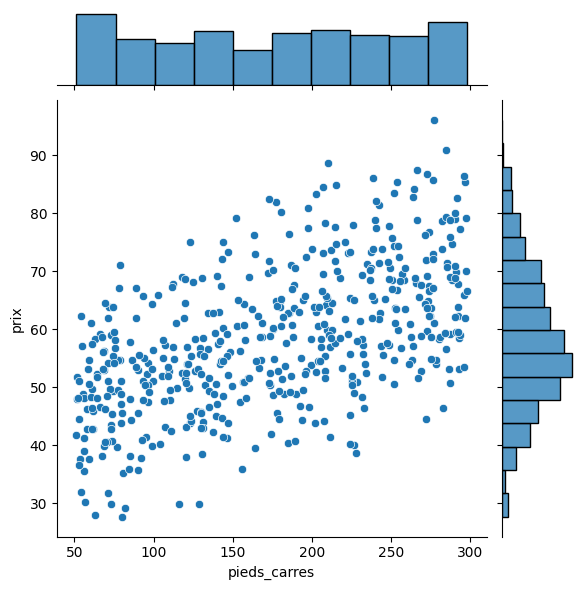

In [31]:
sns.jointplot(x="pieds_carres",y="prix",data=data)

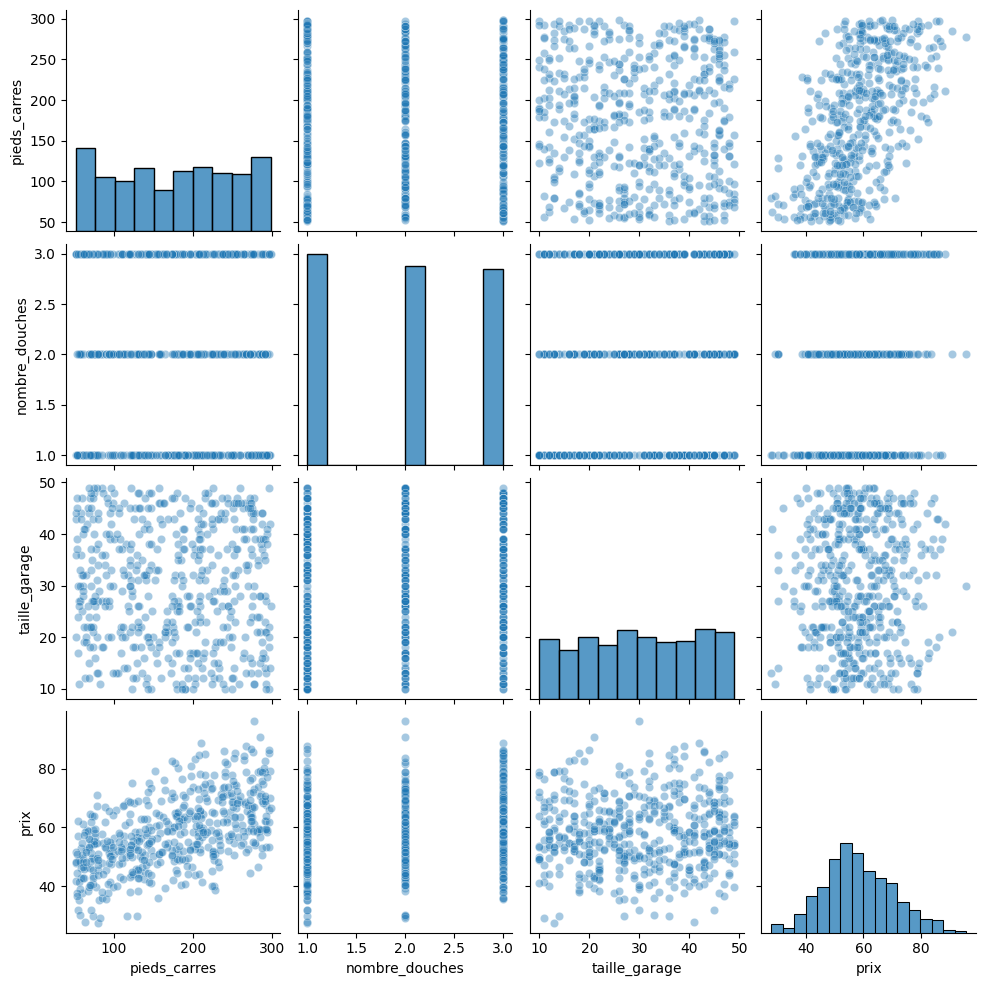

In [32]:
sns.pairplot(data[['pieds_carres','nombre_douches','taille_garage','prix']],kind='scatter',plot_kws={"alpha":0.4})

## Entraînement du modèle

Division des données. Une partie pour l'entraînement, une partie pour l'évaluation du modèle (également appelée test du modèles).

In [33]:
X=data[['pieds_carres','nombre_chambres','nombre_etages','distance_centre_ville']].values#Observations
y=data[['prix']].values#Target (cible)
#2% des données (soit 100 échantillons/samples) seront utilisées pour le test.
#random_state permet  de reproduire la distribution des données d'entraînement et de test.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234)

In [34]:
mlflow.set_experiment('rent_prediction')
mlflow.sklearn.autolog()#Active le tracking de l'expérience avec mlflow

In [35]:
lr=LinearRegression(n_jobs=3)#Initialisation du modèle
#Tous les résultats relatifs à l'entraînement du modèle seront enregistrés dans Mlflow.
with mlflow.start_run() as run:
    lr.fit(X_train,y_train)#Entrainement

## Evaluation du modèle

In [36]:
pred=lr.predict(X_test)

In [37]:
print(f'Dimenssion du vecteur de prédiction {pred.shape}')
print(f'Dimenssion du vecteur de cibles {y_test.shape}')

#Concatenons la prediction et la cible pour avoir une matrice de taille 100 x 2
print(type(y_test))
pred_ytest=np.concatenate([pred,y_test],1)

#Convertir en dataframe pour des raison de visualization.
df_test=pd.DataFrame(pred_ytest)
df_test.head(2)

Dimenssion du vecteur de prédiction (100, 1)
Dimenssion du vecteur de cibles (100, 1)
<class 'numpy.ndarray'>


,0,1
0,65.336137,68.506587
1,54.744179,45.000750


In [38]:
df_test.rename(columns={0:"prediction",1:"cible"},inplace=True)
df_test.head(2)

,prediction,cible
0,65.336137,68.506587
1,54.744179,45.000750


## Analyse des résultats

<Axes: xlabel='prediction', ylabel='cible'>

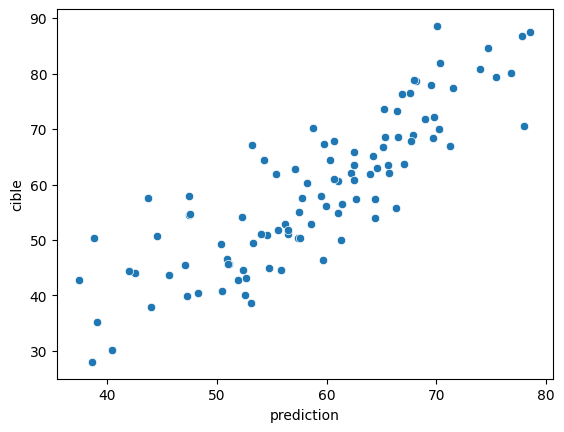

In [39]:
sns.scatterplot(df_test,x='prediction',y='cible')

In [40]:
erreur=mean_squared_error(y_test,pred)
print(f'Erreur {erreur}')

Erreur 51.49107586109007


Condons la fonction d'erreur MSE ci-dessous from scratch avec numpy.

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

In [41]:
erreur=np.sum(np.square(y_test-pred))/len(y_test)
print(f'Erreur {erreur}')

Erreur 51.49107586109007
